In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAEDSprites, Classifier
from utils import latent_transversal, load_checkpoint
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae

In [4]:
whole_dataset = load_dsprites("../datasets/dsprites.npz", False)
dataset = whole_dataset['imgs']
dataset = torch.from_numpy(dataset)

In [29]:
data_size = 10000
data_ = CustomDSpritesDatasetFactorVAE(whole_dataset, data_size)

In [13]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [14]:
model = BetaVAEDSprites()
model.to(device)

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [15]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

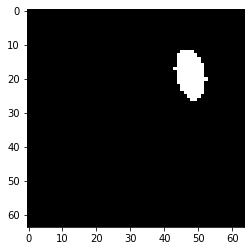

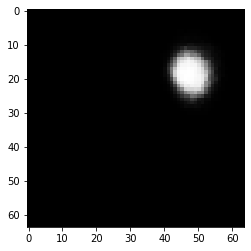

In [30]:
index = 100
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [5]:
len(dataset) / 64

11520.0

None


In [19]:
def compute_latent_gaussian_variance(model, dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    accumulator = torch.zeros(10)
    with torch.no_grad():
        for index, data in enumerate(loader):
            # shape of data is 64 x img_size
            _, _, logvar = model(data.float())
            accumulator = accumulator + logvar.div(2).exp().sum(0)
            if index % 1000 == 999:
                print('.', end='')
            del logvar
    return accumulator.div(len(dataset))

In [31]:
def plot_loss(loss_list, title):
    plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

In [8]:
model_beta1_e40_alldata_n = BetaVAEDSprites()
optimizer = torch.optim.Adagrad(model_beta1_e40_alldata_n.parameters(), lr=1e-2)
start_epoch = 0 
losslogger = []

In [10]:
model_beta1_e40_alldata_n, optimizer, start_epoch, losslogger = load_checkpoint(model_beta1_e40_alldata_n, 
    optimizer, losslogger, 
    filename='trained_models/betavae_beta4_e40_alldata_n.pth.tar')
model_beta1_e40_alldata_n.eval()

=> loading checkpoint 'trained_models/betavae_beta4_e40_alldata_n.pth.tar'
=> loaded checkpoint 'trained_models/betavae_beta4_e40_alldata_n.pth.tar' (epoch 41)


BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [14]:
model_beta1_e40_alldata_n.cpu()
model_beta1_e40_alldata_n

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [30]:
loss = entanglement_metric_factor_vae(model_beta1_e40_alldata_n, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta1_e40_alldata_n, 
                                                  classifier, optimizer, 1000,  data_, 500, 50)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 16.  0.  0.  6.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 18.  0.  0.  0.]
 [ 0.  0.  0. 14.  0.  0.  0.  0.  1.  7.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 21.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. 15.  0.  0.]]
Factor Vae metric: 
Accuracy: 0.84
Beta Vae metric: 
Epoch 0 finished, loss: 1.7120911180973053, accuracy:0.19
Epoch 1 finished, loss: 1.704076924920082, accuracy:0.19
Epoch 2 finished, loss: 1.696861708164215, accuracy:0.19
Epoch 3 finished, loss: 1.6896983921527862, accuracy:0.19
Epoch 4 finished, loss: 1.6829786032438279, accuracy:0.19
Epoch 5 finished, loss: 1.6764672845602036, accuracy:0.19
Epoch 6 finished, loss: 1.6702182382345199, accuracy:0.19
Epoch 7 finished, loss: 1.664202630519867, accuracy:0.19
Epoch 8 finished, loss: 1.658587172627449, accuracy:0.19
Epoch 9 finished, loss: 1.6531268388032914, accuracy:0.19
Epoch 10 finished, loss: 1.6477662175893784, accuracy:0.19
Epoch 11 finished, loss: 1.642840325832367, accuracy:

Epoch 134 finished, loss: 1.4355888694524765, accuracy:0.43
Epoch 135 finished, loss: 1.4343276530504228, accuracy:0.4325
Epoch 136 finished, loss: 1.433138933777809, accuracy:0.4325
Epoch 137 finished, loss: 1.4319433867931366, accuracy:0.435
Epoch 138 finished, loss: 1.4307247281074524, accuracy:0.4375
Epoch 139 finished, loss: 1.4295086324214936, accuracy:0.4425
Epoch 140 finished, loss: 1.4283787667751313, accuracy:0.445
Epoch 141 finished, loss: 1.427139002084732, accuracy:0.445
Epoch 142 finished, loss: 1.4259354412555694, accuracy:0.45
Epoch 143 finished, loss: 1.4247194170951842, accuracy:0.4675
Epoch 144 finished, loss: 1.4235026627779006, accuracy:0.4775
Epoch 145 finished, loss: 1.4222822874784469, accuracy:0.4825
Epoch 146 finished, loss: 1.4211142838001252, accuracy:0.4925
Epoch 147 finished, loss: 1.419932445883751, accuracy:0.4975
Epoch 148 finished, loss: 1.418735271692276, accuracy:0.5125
Epoch 149 finished, loss: 1.4175016552209854, accuracy:0.53
Epoch 150 finished, l

Epoch 274 finished, loss: 1.2765860706567764, accuracy:0.725
Epoch 275 finished, loss: 1.27559095621109, accuracy:0.7225
Epoch 276 finished, loss: 1.2744657337665557, accuracy:0.725
Epoch 277 finished, loss: 1.2734626293182374, accuracy:0.725
Epoch 278 finished, loss: 1.272434514760971, accuracy:0.725
Epoch 279 finished, loss: 1.2713997662067413, accuracy:0.7275
Epoch 280 finished, loss: 1.2702911913394928, accuracy:0.7275
Epoch 281 finished, loss: 1.2692651569843292, accuracy:0.7275
Epoch 282 finished, loss: 1.268244171142578, accuracy:0.73
Epoch 283 finished, loss: 1.2672714740037918, accuracy:0.73
Epoch 284 finished, loss: 1.2661648899316789, accuracy:0.73
Epoch 285 finished, loss: 1.2651439636945725, accuracy:0.73
Epoch 286 finished, loss: 1.264110490679741, accuracy:0.73
Epoch 287 finished, loss: 1.2630628585815429, accuracy:0.73
Epoch 288 finished, loss: 1.2620800107717514, accuracy:0.73
Epoch 289 finished, loss: 1.261035904288292, accuracy:0.735
Epoch 290 finished, loss: 1.26003

Epoch 409 finished, loss: 1.1461319386959077, accuracy:0.785
Epoch 410 finished, loss: 1.145190140604973, accuracy:0.785
Epoch 411 finished, loss: 1.144281952083111, accuracy:0.785
Epoch 412 finished, loss: 1.143425777554512, accuracy:0.785
Epoch 413 finished, loss: 1.1425446763634681, accuracy:0.785
Epoch 414 finished, loss: 1.141650454699993, accuracy:0.785
Epoch 415 finished, loss: 1.1407668203115464, accuracy:0.785
Epoch 416 finished, loss: 1.1398436695337295, accuracy:0.785
Epoch 417 finished, loss: 1.1390187233686446, accuracy:0.785
Epoch 418 finished, loss: 1.1381282582879066, accuracy:0.785
Epoch 419 finished, loss: 1.1372725501656533, accuracy:0.785
Epoch 420 finished, loss: 1.136397297680378, accuracy:0.785
Epoch 421 finished, loss: 1.1355253070592881, accuracy:0.785
Epoch 422 finished, loss: 1.1346317365765572, accuracy:0.785
Epoch 423 finished, loss: 1.1337116584181786, accuracy:0.785
Epoch 424 finished, loss: 1.1328942805528641, accuracy:0.785
Epoch 425 finished, loss: 1.1

Epoch 545 finished, loss: 1.0351388841867446, accuracy:0.8025
Epoch 546 finished, loss: 1.034417125582695, accuracy:0.8025
Epoch 547 finished, loss: 1.0336764588952065, accuracy:0.8025
Epoch 548 finished, loss: 1.0329699471592904, accuracy:0.8025
Epoch 549 finished, loss: 1.03218055665493, accuracy:0.8025
Epoch 550 finished, loss: 1.031451340019703, accuracy:0.8025
Epoch 551 finished, loss: 1.0307082146406175, accuracy:0.8025
Epoch 552 finished, loss: 1.0299386069178582, accuracy:0.8025
Epoch 553 finished, loss: 1.0292165234684945, accuracy:0.805
Epoch 554 finished, loss: 1.028490974009037, accuracy:0.805
Epoch 555 finished, loss: 1.0277570113539696, accuracy:0.8025
Epoch 556 finished, loss: 1.0269658073782921, accuracy:0.8025
Epoch 557 finished, loss: 1.026241771876812, accuracy:0.8025
Epoch 558 finished, loss: 1.025532454252243, accuracy:0.8025
Epoch 559 finished, loss: 1.0248153015971184, accuracy:0.805
Epoch 560 finished, loss: 1.0240635082125664, accuracy:0.805
Epoch 561 finished,

Epoch 682 finished, loss: 0.9414773613214493, accuracy:0.805
Epoch 683 finished, loss: 0.9408844217658043, accuracy:0.805
Epoch 684 finished, loss: 0.9402497857809067, accuracy:0.805
Epoch 685 finished, loss: 0.9396172419190407, accuracy:0.805
Epoch 686 finished, loss: 0.9389940515160561, accuracy:0.805
Epoch 687 finished, loss: 0.9383824869990349, accuracy:0.805
Epoch 688 finished, loss: 0.9377943366765976, accuracy:0.805
Epoch 689 finished, loss: 0.9371899545192719, accuracy:0.805
Epoch 690 finished, loss: 0.9365170821547508, accuracy:0.805
Epoch 691 finished, loss: 0.9359716355800629, accuracy:0.805
Epoch 692 finished, loss: 0.9353200107812881, accuracy:0.805
Epoch 693 finished, loss: 0.9346848472952842, accuracy:0.805
Epoch 694 finished, loss: 0.9341140910983086, accuracy:0.805
Epoch 695 finished, loss: 0.933516825735569, accuracy:0.805
Epoch 696 finished, loss: 0.9329131290316581, accuracy:0.805
Epoch 697 finished, loss: 0.9322387486696243, accuracy:0.805
Epoch 698 finished, loss:

Epoch 817 finished, loss: 0.864827336370945, accuracy:0.8075
Epoch 818 finished, loss: 0.8643265724182129, accuracy:0.8075
Epoch 819 finished, loss: 0.863782799243927, accuracy:0.8075
Epoch 820 finished, loss: 0.8632969245314598, accuracy:0.8075
Epoch 821 finished, loss: 0.8627823770046235, accuracy:0.8075
Epoch 822 finished, loss: 0.8622479185461998, accuracy:0.8075
Epoch 823 finished, loss: 0.8617481470108033, accuracy:0.8075
Epoch 824 finished, loss: 0.8612018600106239, accuracy:0.8075
Epoch 825 finished, loss: 0.8607539296150207, accuracy:0.8075
Epoch 826 finished, loss: 0.8601640611886978, accuracy:0.8075
Epoch 827 finished, loss: 0.8596940562129021, accuracy:0.8075
Epoch 828 finished, loss: 0.8592250064015389, accuracy:0.8075
Epoch 829 finished, loss: 0.8586180284619331, accuracy:0.8075
Epoch 830 finished, loss: 0.8581425607204437, accuracy:0.8075
Epoch 831 finished, loss: 0.8575997829437256, accuracy:0.8075
Epoch 832 finished, loss: 0.8571165725588799, accuracy:0.8075
Epoch 833 

Epoch 953 finished, loss: 0.8002018839120865, accuracy:0.81
Epoch 954 finished, loss: 0.799787849187851, accuracy:0.81
Epoch 955 finished, loss: 0.7994176484644413, accuracy:0.81
Epoch 956 finished, loss: 0.7989073976874351, accuracy:0.81
Epoch 957 finished, loss: 0.7984395250678062, accuracy:0.81
Epoch 958 finished, loss: 0.7980972930788994, accuracy:0.81
Epoch 959 finished, loss: 0.7975846573710441, accuracy:0.81
Epoch 960 finished, loss: 0.7971542805433274, accuracy:0.81
Epoch 961 finished, loss: 0.7967872008681297, accuracy:0.81
Epoch 962 finished, loss: 0.7962910532951355, accuracy:0.81
Epoch 963 finished, loss: 0.7958976477384567, accuracy:0.81
Epoch 964 finished, loss: 0.7954506933689117, accuracy:0.81
Epoch 965 finished, loss: 0.7950294017791748, accuracy:0.81
Epoch 966 finished, loss: 0.7945835903286934, accuracy:0.81
Epoch 967 finished, loss: 0.7942692995071411, accuracy:0.81
Epoch 968 finished, loss: 0.7937443628907204, accuracy:0.81
Epoch 969 finished, loss: 0.7933131188154

NameError: name 'plot_loss' is not defined

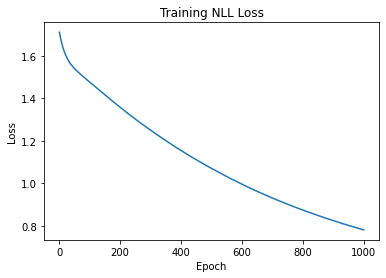

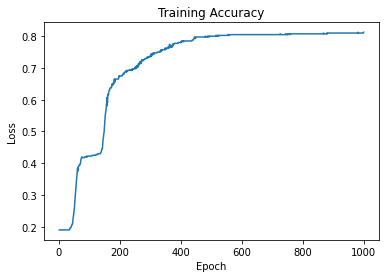

In [32]:
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")

In [33]:
torch.save(model_beta1_e40_alldata_n, 'trained_models/model_beta1_e40_alldata_n.dat')

In [21]:
latent_gaussian_variance_beta4_n = compute_latent_gaussian_variance(model_beta1_e40_alldata_n, dataset)
print(latent_gaussian_variance_beta4_n)

...........tensor([0.9926, 0.9936, 0.9948, 0.3158, 0.9926, 0.9931, 0.1109, 0.0412, 0.0673,
        0.1960])


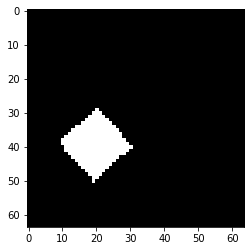

In [24]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()
plt.imshow(torch.sigmoid(original.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [25]:
recon, mu, logvar = model_beta1_e40_alldata_n(original)

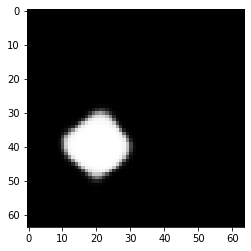

In [26]:
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

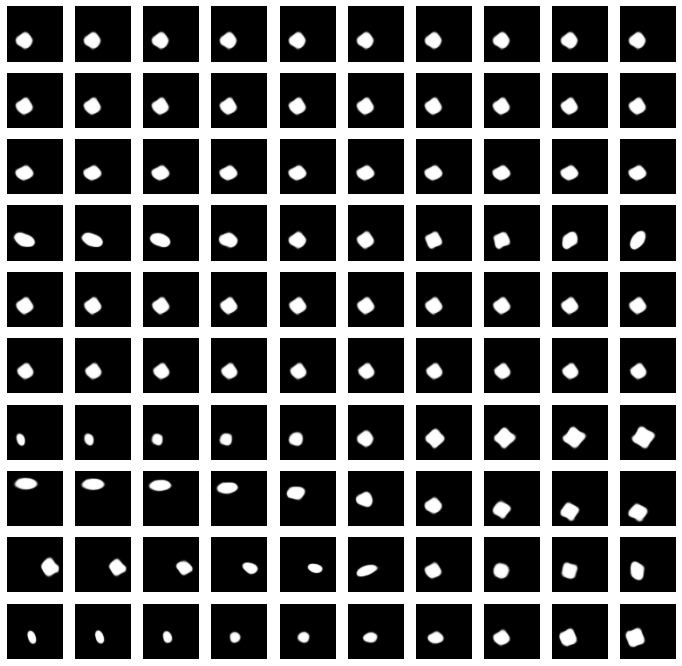

In [27]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model_beta1_e40_alldata_n, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [34]:
model_beta1_e100_alldata_n = BetaVAEDSprites()
optimizer = torch.optim.Adagrad(model_beta1_e100_alldata_n.parameters(), lr=1e-2)
start_epoch = 0 
losslogger = []

In [35]:
model_beta1_e100_alldata_n, optimizer, start_epoch, losslogger = load_checkpoint(model_beta1_e100_alldata_n, 
    optimizer, losslogger, 
    filename='trained_models/betavae_beta4_e100_alldata_n.pth.tar')
model_beta1_e100_alldata_n.eval()

=> loading checkpoint 'trained_models/betavae_beta4_e100_alldata_n.pth.tar'
=> loaded checkpoint 'trained_models/betavae_beta4_e100_alldata_n.pth.tar' (epoch 101)


BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [36]:
model_beta1_e100_alldata_n.cpu()
model_beta1_e100_alldata_n

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [ ]:
loss = entanglement_metric_factor_vae(model_beta1_e100_alldata_n, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta1_e100_alldata_n, 
                                                  classifier, optimizer, 1000,  data_, 500, 50)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 14.  0.  0.  4.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 23.  0.  0.  0.]
 [ 0.  0.  0. 16.  0.  0.  0.  0.  1.  5.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 17.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 20.  0.  0.]]
Factor Vae metric: 
Accuracy: 0.9
Beta Vae metric: 


In [33]:
torch.save(model_beta1_e40_alldata_n, 'trained_models/model_beta1_e100_alldata_n.dat')

In [21]:
latent_gaussian_variance_beta4_n = compute_latent_gaussian_variance(model_beta1_e40_alldata_n, dataset)
print(latent_gaussian_variance_beta4_n)

...........tensor([0.9926, 0.9936, 0.9948, 0.3158, 0.9926, 0.9931, 0.1109, 0.0412, 0.0673,
        0.1960])


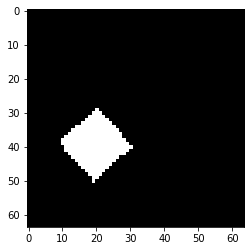

In [24]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()
plt.imshow(torch.sigmoid(original.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [25]:
recon, mu, logvar = model_beta1_e40_alldata_n(original)

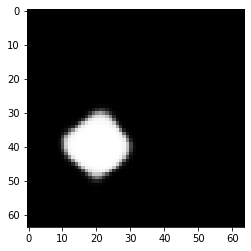

In [26]:
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

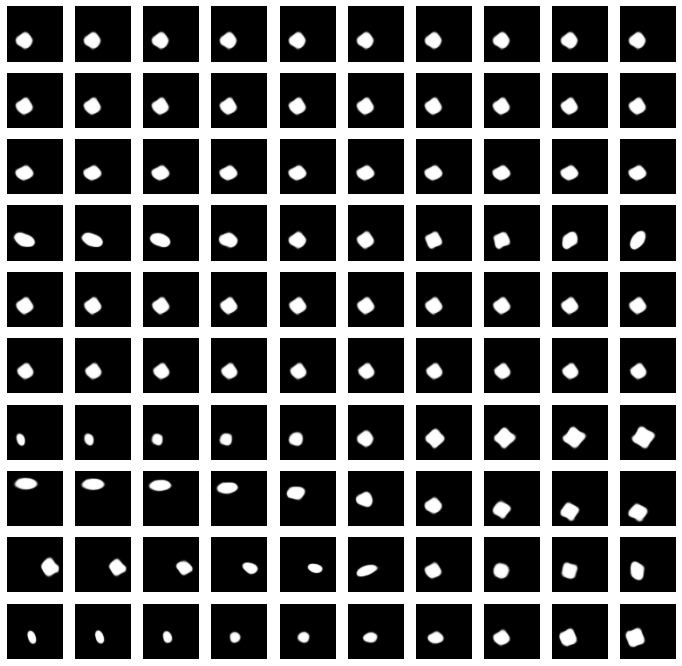

In [27]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model_beta1_e40_alldata_n, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [30]:
model_beta1_e40_alldata = torch.load('trained_models/betavae_beta1_e40_alldata.dat')
model_beta1_e40_alldata.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  6.  4.  1.  2.  5.  0.  0.  4.  0.]
 [ 0.  0.  4.  0. 10.  0.  0.  0.  2.  0.]
 [ 4.  0.  4.  3.  2.  0.  0.  7.  0.  3.]
 [ 1.  0.  3.  0.  0.  0.  6.  1.  0.  8.]
 [20.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Factor Vae metric: 
Accuracy: 0.51
Beta Vae metric: 
Epoch 0 finished, loss: 1.6710106402635574, accuracy:0.16375
Epoch 1 finished, loss: 1.6667605459690094, accuracy:0.165
Epoch 2 finished, loss: 1.662931926548481, accuracy:0.16875
Epoch 3 finished, loss: 1.6594409078359604, accuracy:0.1675
Epoch 4 finished, loss: 1.6560884535312652, accuracy:0.17
Epoch 5 finished, loss: 1.6530262008309364, accuracy:0.17
Epoch 6 finished, loss: 1.650194674730301, accuracy:0.17125
Epoch 7 finished, loss: 1.6475941717624665, accuracy:0.1675
Epoch 8 finished, loss: 1.6451336145401, accuracy:0.1675
Epoch 9 finished, loss: 1.6429397389292717, accuracy:0.16625
Epoch 10 finished, loss: 1.640892541408539, accuracy:0.165
Epoch 11 finished, loss: 1.63889794

Epoch 134 finished, loss: 1.5781890124082565, accuracy:0.2475
Epoch 135 finished, loss: 1.5779826655983924, accuracy:0.2475
Epoch 136 finished, loss: 1.5776745676994324, accuracy:0.24625
Epoch 137 finished, loss: 1.5774048954248427, accuracy:0.25
Epoch 138 finished, loss: 1.5771436408162116, accuracy:0.24875
Epoch 139 finished, loss: 1.576828770339489, accuracy:0.25125
Epoch 140 finished, loss: 1.5765441060066223, accuracy:0.2525
Epoch 141 finished, loss: 1.5762665003538132, accuracy:0.25
Epoch 142 finished, loss: 1.575998416543007, accuracy:0.2525
Epoch 143 finished, loss: 1.5757728219032288, accuracy:0.25375
Epoch 144 finished, loss: 1.5754419967532158, accuracy:0.255
Epoch 145 finished, loss: 1.5751987248659134, accuracy:0.25875
Epoch 146 finished, loss: 1.574925796687603, accuracy:0.2625
Epoch 147 finished, loss: 1.5746350452303886, accuracy:0.26
Epoch 148 finished, loss: 1.5744030624628067, accuracy:0.26125
Epoch 149 finished, loss: 1.5741095140576362, accuracy:0.26375
Epoch 150 f

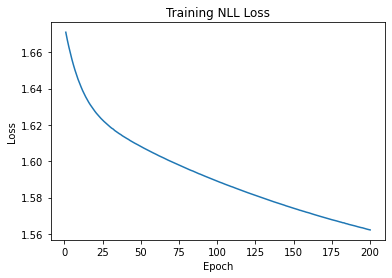

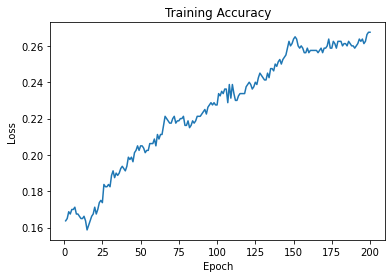

In [31]:
loss = entanglement_metric_factor_vae(model_beta1_e40_alldata, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta1_e40_alldata, classifier, optimizer, 1000,  data_, 500, 50, device)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")

In [13]:
latent_gaussian_variance_beta1 = compute_latent_gaussian_variance(model_beta1_e40_alldata, dataset)

...........

In [14]:
print(latent_gaussian_variance_beta1)

tensor([0.0094, 0.0634, 0.0134, 0.0451, 0.0390, 0.0524, 0.0099, 0.0142, 0.1327,
        0.0124])


In [1]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float().to(device)


NameError: name 'np' is not defined

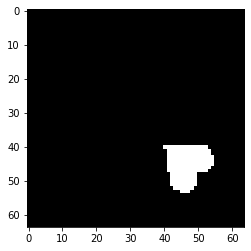

In [17]:
plt.imshow(torch.sigmoid(original.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [18]:
recon, mu, logvar = model_beta1_e40_alldata(original)

In [19]:
logvar.div(2).exp()

tensor([[0.0094, 0.0554, 0.0182, 0.0401, 0.0399, 0.0454, 0.0093, 0.0220, 0.2406,
         0.0106]], device='cuda:0', grad_fn=<ExpBackward>)

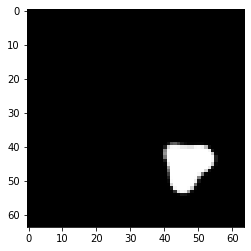

In [21]:
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

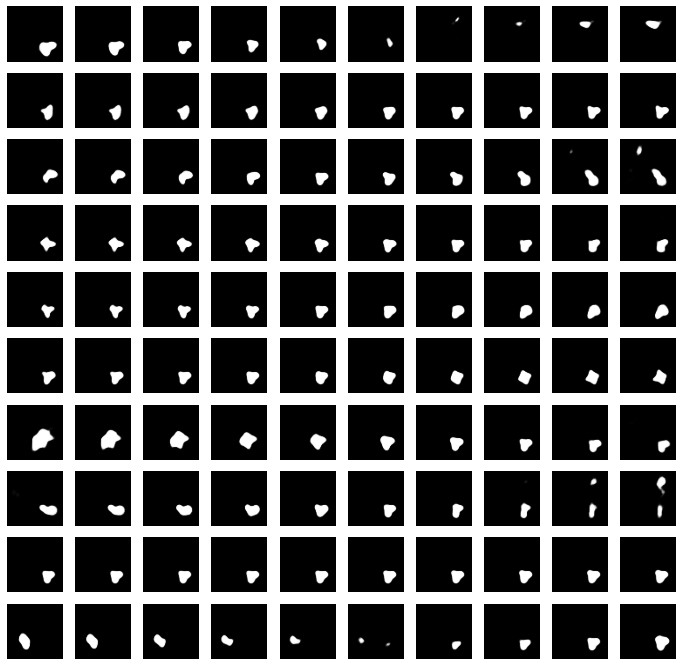

In [20]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model_beta1_e40_alldata, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [5]:
from utils import save_checkpoint, load_checkpoint

In [9]:
model = BetaVAEDSprites()
model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)
losslogger = []

In [11]:
model_beta4_e100, optimizer, start_epoch, losslogger = load_checkpoint(
    model, optimizer, losslogger,
    'trained_models/betavae_beta4_e100_alldata.pth.tar')

=> loading checkpoint 'trained_models/betavae_beta4_e100_alldata.pth.tar'
=> loaded checkpoint 'trained_models/betavae_beta4_e100_alldata.pth.tar' (epoch 101)


In [12]:
model_beta4_e100(dataset[0].float().to(device))

(tensor([[-22.1766, -21.6752, -22.0266,  ..., -22.2811, -22.0703, -21.9393]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.6407,  0.3896,  1.2050, -0.0108, -0.7347,  1.5645,  0.0088, -0.5321,
           0.7589, -0.0401]], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[-5.9687, -4.9327, -6.1625, -0.0626, -6.8360, -7.9847, -0.0889, -8.4066,
          -8.3986, -0.0898]], device='cuda:0', grad_fn=<SliceBackward>))

In [25]:
latent_gaussian_variance_beta4 = compute_latent_gaussian_variance(model_beta4_e100, dataset)
print(latent_gaussian_variance_beta4)

...........tensor([0.0414, 0.0913, 0.0380, 0.9566, 0.0316, 0.0158, 0.9635, 0.0189, 0.0130,
        0.9602])


In [13]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float().to(device)


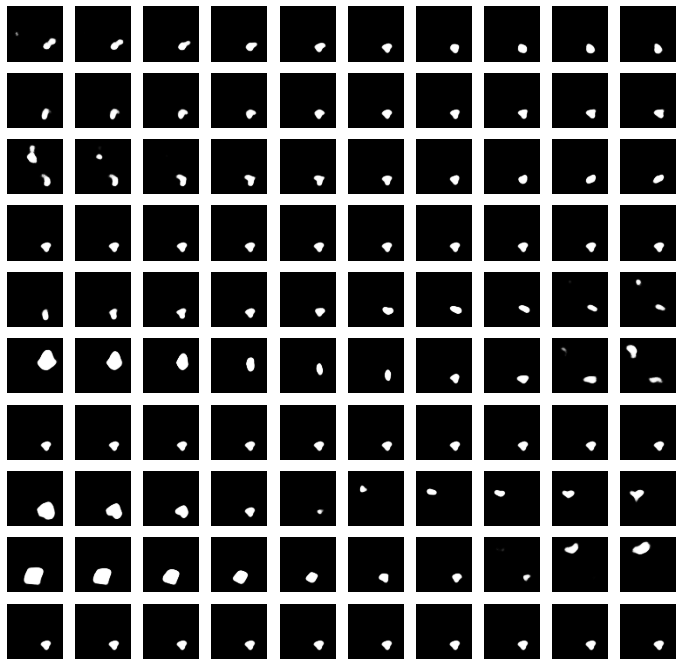

In [14]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [21]:
model_beta4_e100.cpu()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 9.  9.  0.  0.  0.  2.  0.  2.  2.  0.]
 [ 0.  4.  6.  3.  0.  0.  1.  0.  0.  3.]
 [14.  1.  0.  0.  4.  0.  0.  0.  5.  0.]
 [ 0.  0.  2.  0.  6.  6.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  3.  4.  0.  2. 10.  0.]]
Factor Vae metric: 
Accuracy: 0.44999999999999996
Beta Vae metric: 
Epoch 0 finished, loss: 1.6275816917419434, accuracy:0.1925
Epoch 1 finished, loss: 1.626277008652687, accuracy:0.19625
Epoch 2 finished, loss: 1.625090028345585, accuracy:0.19625
Epoch 3 finished, loss: 1.6239756524562836, accuracy:0.19625
Epoch 4 finished, loss: 1.6228930607438088, accuracy:0.19375
Epoch 5 finished, loss: 1.6219044610857964, accuracy:0.195
Epoch 6 finished, loss: 1.6209238588809967, accuracy:0.195
Epoch 7 finished, loss: 1.6200217470526694, accuracy:0.19125
Epoch 8 finished, loss: 1.6191286817193031, accuracy:0.1925
Epoch 9 finished, loss: 1.6182975947856904, accuracy:0.19125
Epoch 10 finished, loss: 1.6175555661320686, accuracy:0.195
Epoch 11 fi

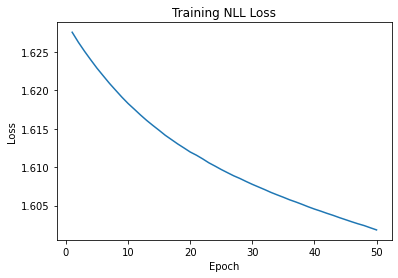

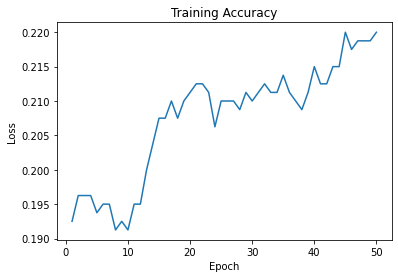

In [24]:
loss = entanglement_metric_factor_vae(model_beta4_e100, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta4_e100, classifier, optimizer, 50,  data_, 1000, 10)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")

In [27]:
model_beta4_e40_alldata = torch.load('trained_models/betavae_beta4_e40_alldata.dat')
model_beta4_e40_alldata.cpu()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 16.  8.  0.  3.  0.  0.  0.  0.]
 [ 2.  0.  3.  0.  0. 11.  4.  0.  0.  6.]
 [ 0.  0. 10.  2.  0.  3.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  8.  0.  0.  7.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 16.  0.]]
Factor Vae metric: 
Accuracy: 0.61
Beta Vae metric: 
Epoch 0 finished, loss: 1.6715067833662034, accuracy:0.1725
Epoch 1 finished, loss: 1.667233557999134, accuracy:0.17125
Epoch 2 finished, loss: 1.6632487550377846, accuracy:0.1725
Epoch 3 finished, loss: 1.6594988226890564, accuracy:0.17375
Epoch 4 finished, loss: 1.6559909299015998, accuracy:0.17375
Epoch 5 finished, loss: 1.6527004778385161, accuracy:0.17375
Epoch 6 finished, loss: 1.6496044412255286, accuracy:0.1675
Epoch 7 finished, loss: 1.6466932490468025, accuracy:0.16625
Epoch 8 finished, loss: 1.643994389474392, accuracy:0.16875
Epoch 9 finished, loss: 1.6413757890462874, accuracy:0.1725
Epoch 10 finished, loss: 1.6389542564749717, accuracy:0.1725
Epoch 11 finished, loss

Epoch 131 finished, loss: 1.565345761179924, accuracy:0.3025
Epoch 132 finished, loss: 1.5650042921304703, accuracy:0.30375
Epoch 133 finished, loss: 1.5647007644176483, accuracy:0.30375
Epoch 134 finished, loss: 1.5643965259194375, accuracy:0.305
Epoch 135 finished, loss: 1.5640531063079834, accuracy:0.305
Epoch 136 finished, loss: 1.5637504518032075, accuracy:0.305
Epoch 137 finished, loss: 1.5634283050894737, accuracy:0.305
Epoch 138 finished, loss: 1.563120184838772, accuracy:0.30625
Epoch 139 finished, loss: 1.5627879217267036, accuracy:0.30625
Epoch 140 finished, loss: 1.5624735668301581, accuracy:0.305
Epoch 141 finished, loss: 1.562188918888569, accuracy:0.30375
Epoch 142 finished, loss: 1.5618487000465393, accuracy:0.305
Epoch 143 finished, loss: 1.5615535020828246, accuracy:0.30375
Epoch 144 finished, loss: 1.561227560043335, accuracy:0.30625
Epoch 145 finished, loss: 1.5609609976410865, accuracy:0.30625
Epoch 146 finished, loss: 1.5606245830655099, accuracy:0.30625
Epoch 147

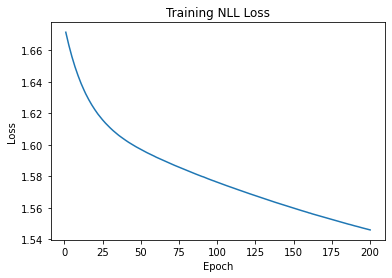

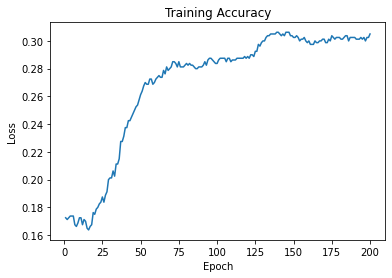

In [29]:
loss = entanglement_metric_factor_vae(model_beta4_e40_alldata, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta4_e40_alldata, classifier, optimizer, 200,  data_, 1000, 10)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")